In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utils import plot_pred_v_truth

## Combine all dfs into single dataset

In [2]:
# Read all dataframes into numpy arrays
df05 = pd.read_csv("../data/pulse_data/pulse_response_T0.csv", header=None).to_numpy()
df1 = pd.read_csv("../data/pulse_data/pulse_response_T1(in).csv", header=None).to_numpy()
df5 = pd.read_csv("../data/pulse_data/pulse_response_T5(in).csv", header=None).to_numpy()
df10 = pd.read_csv("../data/pulse_data/pulse_response_T10(in).csv", header=None).to_numpy()
df50 = pd.read_csv("../data/pulse_data/pulse_response_T50(in).csv", header=None).to_numpy()
df100 = pd.read_csv("../data/pulse_data/pulse_response_T100(in).csv", header=None).to_numpy()

# Combine into a list
dfs = [df05, df1, df5, df10, df50, df100]
signal_names = ['T0.5', 'T1','T5', 'T10', 'T50', 'T100']

# Extract time, input, output for each dataframe
time = np.array([df[:, 0] for df in dfs])
input_signal = np.array([df[:, 1] for df in dfs])
output_signal = np.array([df[:, 2] for df in dfs])

# Save each as a CSV file (rows: signals, columns: time series values)
# np.savetxt("pulse_data/time.csv", time, delimiter=",")
# np.savetxt("pulse_data/input_signal.csv", input_signal, delimiter=",")
# np.savetxt("pulse_data/output_signal.csv", output_signal, delimiter=",")

In [3]:
time.shape, input_signal.shape, output_signal.shape

((6, 2001), (6, 2001), (6, 2001))

In [4]:
time[-1]

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.998e+02, 1.999e+02,
       2.000e+02])

## Generate Heaviside examples

In [5]:
df = pd.read_csv("../data/pulse_data/pulse_response_T5(in).csv",header = None).to_numpy()

time = df[:, 0]
input_signal = df[:, 1]
output_signal = df[:, 2]

N = time.shape[0]

g_hat = np.fft.fft(output_signal)
f_hat = np.fft.fft(input_signal)
H_hat = g_hat / f_hat
H = np.fft.ifft(H_hat)

In [6]:
samples = 1500

N = time.shape[0]
input_signals = np.zeros((samples, len(time)))

start_impulse = np.random.randint(20, N-200, size = samples)
for i in range(samples):
    max_time_for_impulse = N - start_impulse[i] - 50
    length_impulse = np.random.randint(5, max_time_for_impulse)
    input_signals[i, start_impulse[i]:length_impulse + start_impulse[i]] = 1

output_signals = np.zeros_like(input_signals)

input_hat = np.fft.fft(input_signals, axis=1)

for i,sig in enumerate(input_signals):
    u_hat = H_hat * input_hat[i]
    u = np.fft.ifft(u_hat) 
    output_signals[i] = u

C:\Users\mathi\AppData\Local\Temp\ipykernel_39136\2534073479.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  output_signals[i] = u


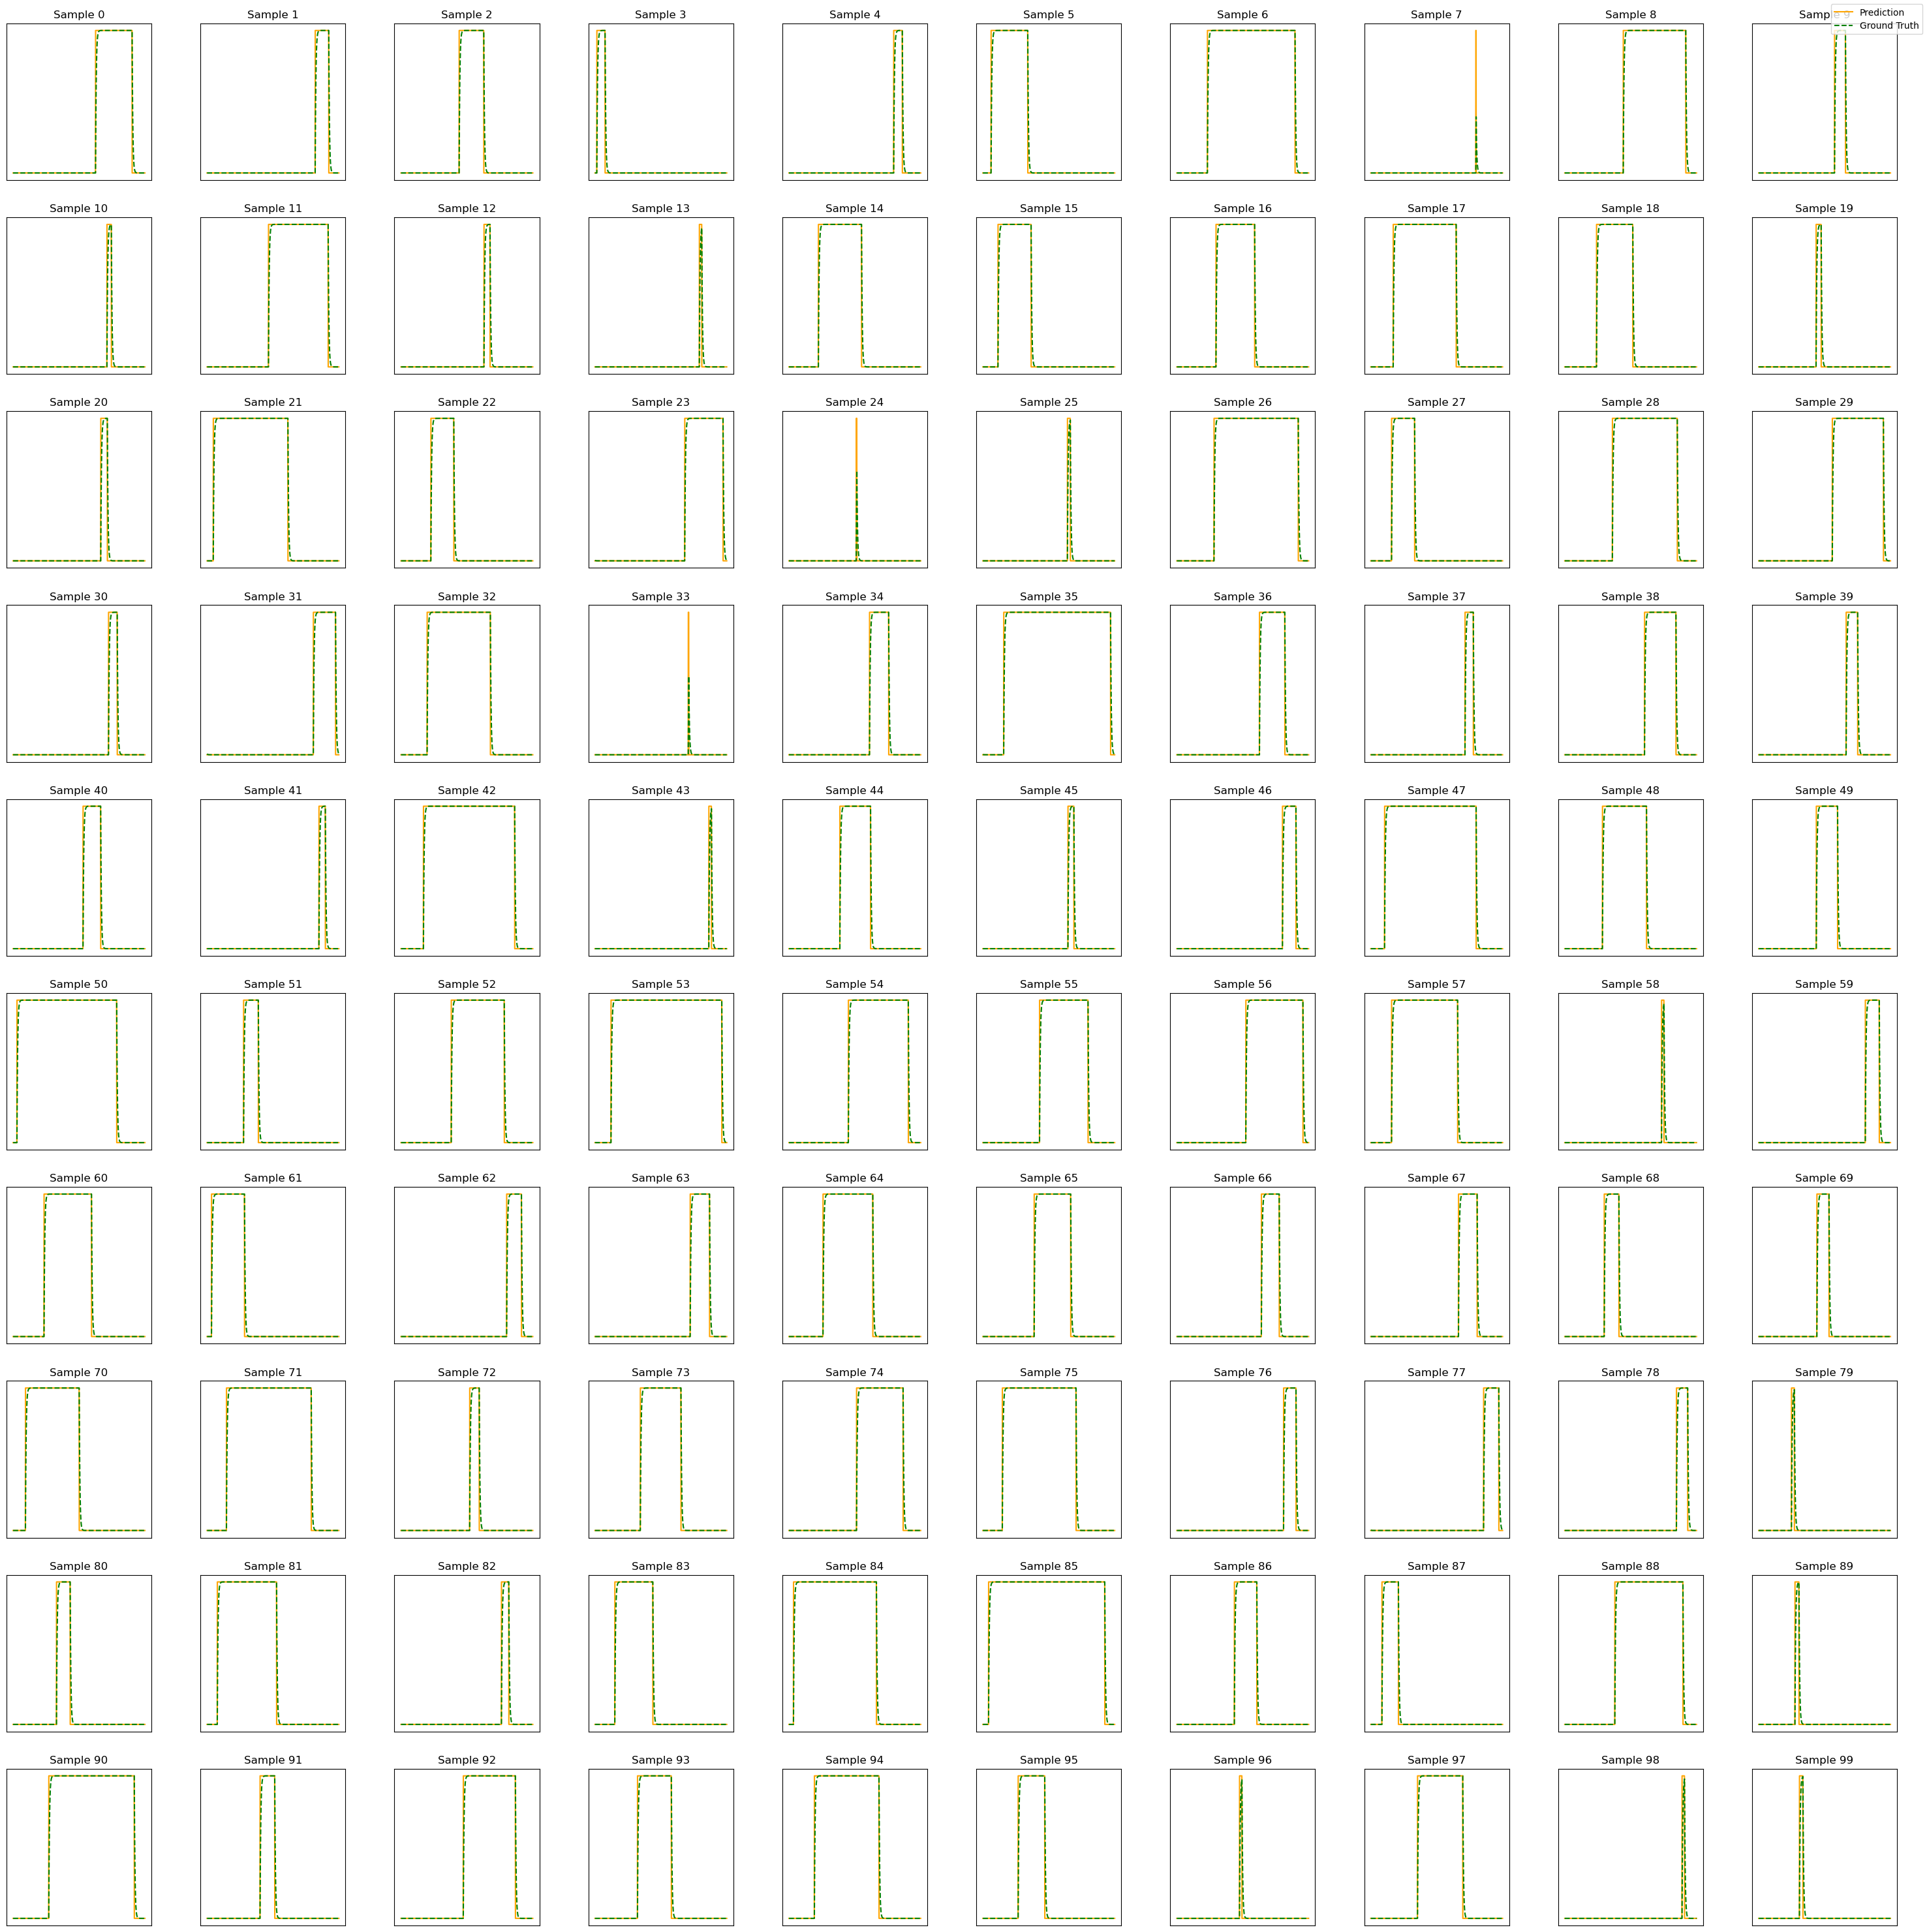

In [7]:
plot_pred_v_truth(time, input_signals[:, np.newaxis, :], output_signals[:, np.newaxis, :])

In [8]:
# train_x, train_y = input_signals[:1000], output_signals[:1000]
# test_x, test_y = input_signals[1000:], output_signals[1000:]

# pd.DataFrame(train_x).to_csv("pulse_data/train_x.csv", index=False)
# pd.DataFrame(train_y).to_csv("pulse_data/train_y.csv", index=False)
# pd.DataFrame(test_x).to_csv("pulse_data/test_x.csv", index=False)
# pd.DataFrame(test_y).to_csv("pulse_data/test_y.csv", index=False)


## Generate other functions

In [9]:
from scipy.signal.windows import triang

samples = 4
num_of_coeffs = 3

phase = np.random.uniform(0 , 2 * np.pi, (samples, num_of_coeffs))
freqs = np.random.uniform(0 , 0.1, (samples, num_of_coeffs))
multipliers = np.random.uniform(-2 , 2, (samples, num_of_coeffs))

input_signals = np.zeros((16, len(time)))

for j in range(samples):
    for i in range(num_of_coeffs):
        input_signals[j] += multipliers[j, i] * np.sin(2 * np.pi * freqs[j, i] * time + phase[j, i])

# --- Sinusoidal pulses with different start times and durations ---
pulse_starts = [20, 50, 10, 100]      # start times in seconds for each sinusoidal signal
pulse_durations = [40, 30, 60, 50]    # durations in seconds for each sinusoidal signal
frequencies = [0.005, 0.005, 0.005, 0.005]  # Hz
amplitudes = [1, 0.8, 0.6, 0.4]

for i in range(4):
    # Compute half-period duration in seconds
    half_period = 0.5 / frequencies[i]
    pulse_samples = int(half_period / (time[1] - time[0]))

    # Choose start index for the pulse (can be different for each signal)
    start_idx = int(pulse_starts[i] / (time[1]-time[0]))
    end_idx = start_idx + pulse_samples
    end_idx = min(end_idx, N)

    # Generate time segment for this pulse
    t_pulse = time[start_idx:end_idx] - time[start_idx]  # shift so pulse starts at 0

    # Sinusoidal pulse starting at 0 and ending at 0 after half a period
    input_signals[4 + i, start_idx:end_idx] = amplitudes[i] * np.sin(2 * np.pi * frequencies[i] * t_pulse)

# --- Triangular pulses with different start times and durations ---
tri_pulse_starts = [30, 70, 20, 120]
tri_pulse_durations = [50, 40, 60, 30]
tri_amplitudes = [1, 0.8, 0.6, 0.4]

for i in range(4):
    start_idx = int(tri_pulse_starts[i] / (time[1]-time[0]))
    end_idx = start_idx + int(tri_pulse_durations[i] / (time[1]-time[0]))
    end_idx = min(end_idx, N)
    tri_pulse = triang(end_idx - start_idx)
    input_signals[8+i, start_idx:end_idx] = tri_amplitudes[i] * tri_pulse

# --- Gaussian signals (centered at different times, different widths) ---
def gaussian(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

gaussian_mus = [40, 60, 80, 100]  # center of pulse in seconds
gaussian_sigmas = [7, 5, 4, 3]

for i in range(4):
    input_signals[12+i] = gaussian(time, mu=gaussian_mus[i], sigma=gaussian_sigmas[i])

output_signals = np.zeros_like(input_signals)

for i in range(16):
    u = np.fft.ifft(H_hat * np.fft.fft(input_signals[i]))
    output_signals[i] = u


C:\Users\mathi\AppData\Local\Temp\ipykernel_39136\2933971401.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
  output_signals[i] = u


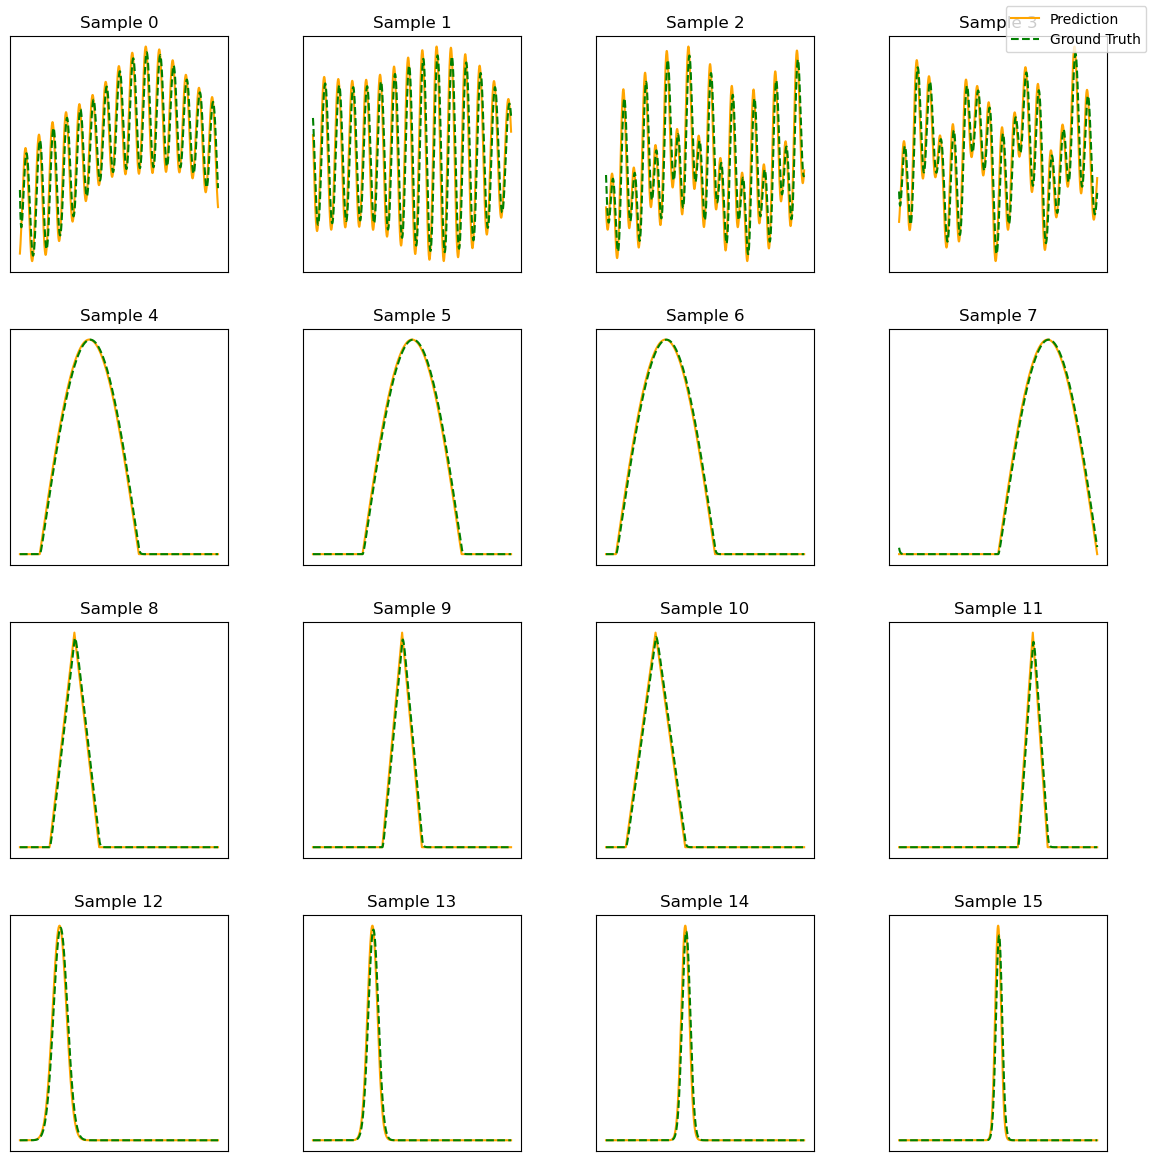

In [10]:
plot_pred_v_truth(time, input_signals[:, np.newaxis, :], output_signals[:, np.newaxis, :])

In [11]:
pd.DataFrame(input_signals).to_csv("../data/pulse_data/outOfDist_x.csv", index=False)
pd.DataFrame(output_signals).to_csv("../data/pulse_data/outOfDist_y.csv", index=False)